/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


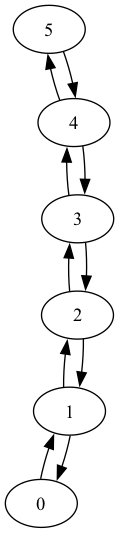

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

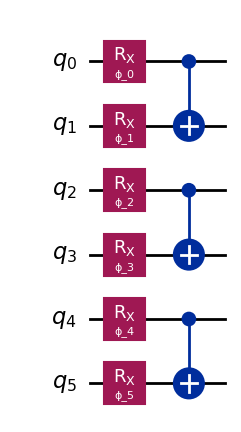

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


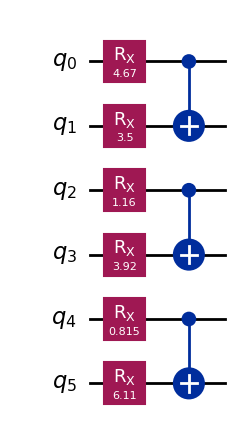

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

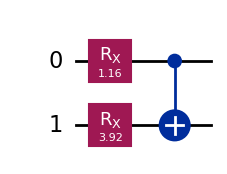

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

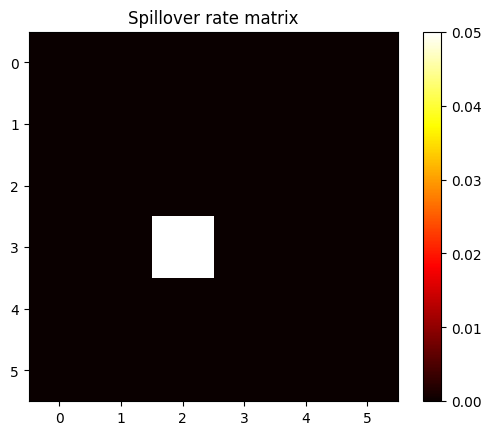

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

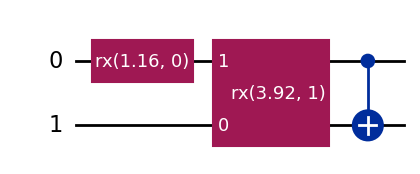

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j],
       [0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 2)), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbit

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '8cce87dfef3e43fcb9a3320e5ff7ed8c',
   'operations': ['h'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '8cce87dfef3e43fcb9a3320e5ff7ed8c',
   'operations': ['x'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '8cce87dfef3e43fcb9a3320e5ff7ed8c',
   'operations': ['s'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qub

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15c7e8d50>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '8cce87dfef3e43fcb9a3320e5ff7ed8c',
   'operations': ['h'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '8cce87dfef3e43fcb9a3320e5ff7ed8c',
   'operations': ['x'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '8cce87dfef3e43fcb9a3320e5ff7ed8c',
   'operations': ['s'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qub

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


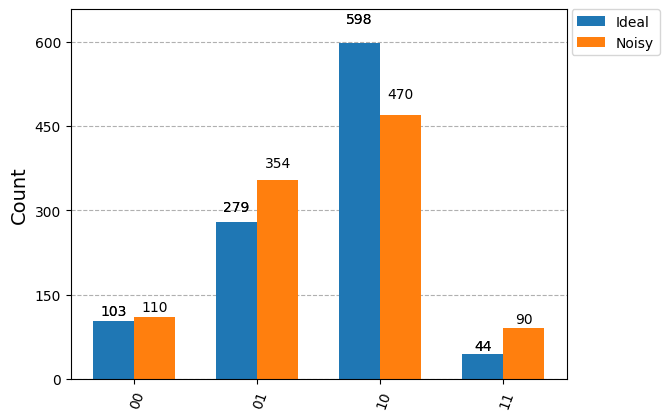

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9923231967419589

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -np.pi/2,
        np.pi/2,
        q_reg[0],
    )
    my_qc.u(
        0.,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.5, high=0.5, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=5,
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
# q_env = ArbitraryAngleSpilloverEnv(
#     q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
# )

In [22]:
# Constructing single angle spillover env

from single_angle_spillover_env import OneParamAngleSpilloverEnv

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [23]:
_, _ = one_env.reset(debug_obs=np.array([np.pi]))
# _, _ = one_env.reset()

Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]


Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9816424363532725 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9609443990519717 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9235667991436433 Std: 0.0
Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8682189595720547 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8072189573633735 Std: 0.0
Number of repetitions: 11
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity 

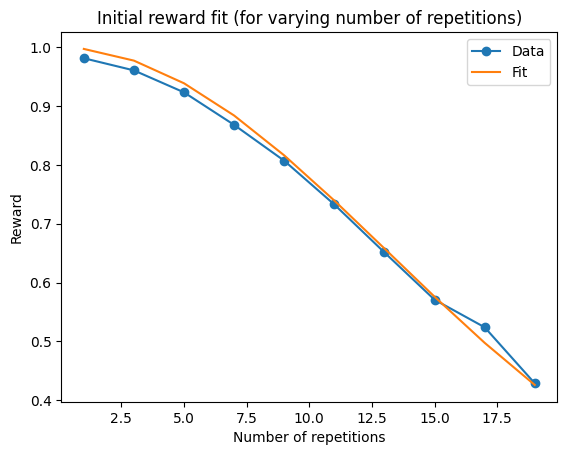

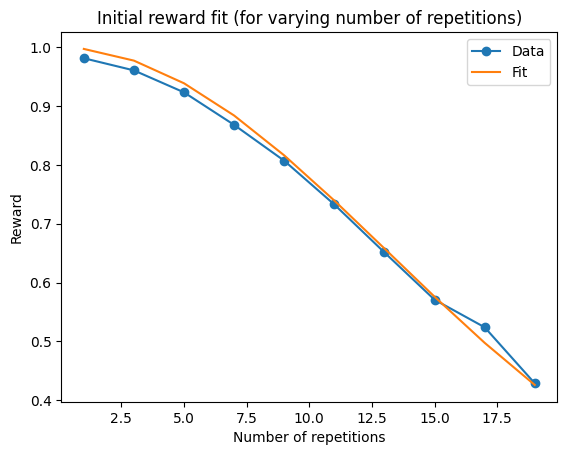

In [24]:
one_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 20, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="channel",
)

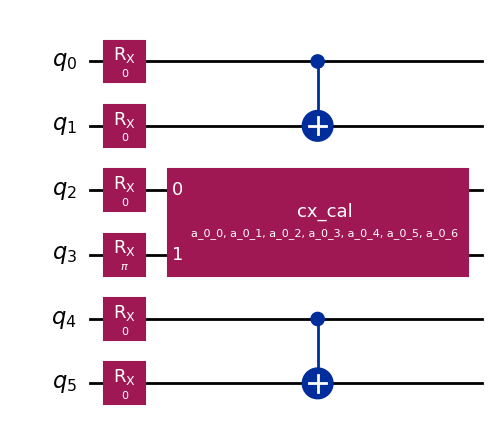

In [25]:
one_env.circuits[0].draw('mpl')

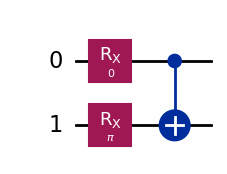

In [26]:
one_env.target.causal_cone_circuit.draw("mpl")

In [27]:
one_env.perform_action(np.zeros((1, 7)))

Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9313848047403341 Std: 0.0


array([0.9313848])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9950753362380551 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.975618457856409 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.937892120274873 Std: 0.0
Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8841725877461318 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8176370356758362 Std: 0.0
Number of repetitions: 11
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (p

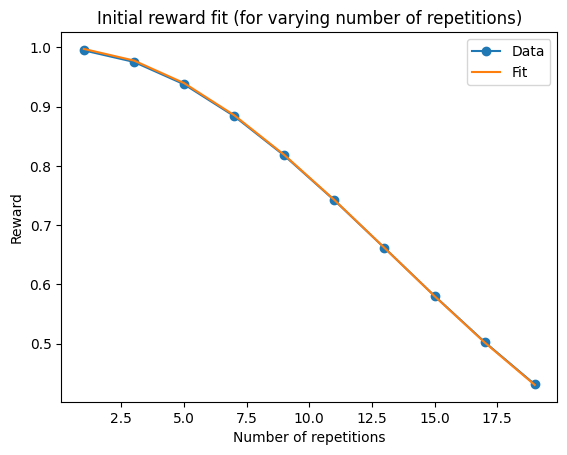

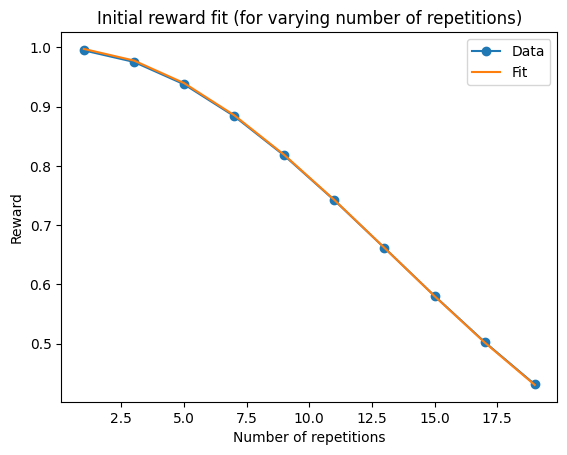

In [28]:
one_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 20, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
)

In [33]:
baseline_reward = []

one_env.clear_history()
for set_obs in one_env.discrete_obs_vals_angles:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = one_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((one_env.batch_size,) + one_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = one_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {one_env.discrete_reward_history}")

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 0.9861806439090839 Std: 0.010701920273102542
obs: [-1.]
reward: [2.38104244 6.         1.55551966 1.70462241 6.         1.76647117
 6.         2.15297348 1.48132545 2.09586231 1.94889862 1.62609995
 1.99071024 1.75155937 6.         1.79927956 1.76719545 1.86026695
 1.47270882 1.93111023 2.11177413 1.91045508 1.90337233 1.93409517
 1.78556618 1.42013714 1.51428303 1.81091187 2.37796624 2.36678508
 1.86928213 1.75748209]
discrete reward history: [[2.37649239 1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
(32, 7)
batch action shape: (32, 7)
Starting 

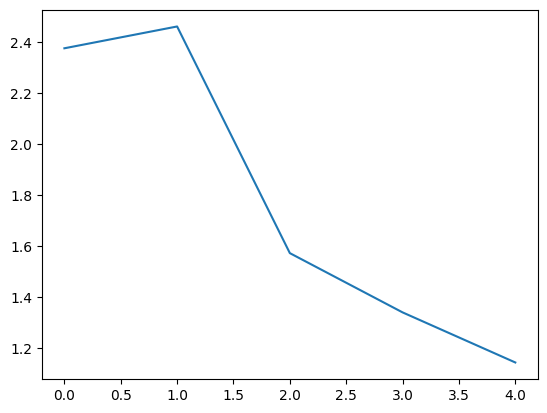

In [34]:
plt.plot(baseline_reward)

In [24]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(one_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [29]:
# Testing the optimal policy in advance

single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=1000,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [30]:
# Testing fidelity of agents

import copy
import torch

rewards = []

# action_test = copy.deepcopy(actions)
o_vals = one_env.discrete_obs_vals_angles
ana_sum = -o_vals * 0.05 # gamma value
ana_scaled = ana_sum / 0.5 # env action space bounds

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals_angles):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = ppo_agent.env.unwrapped.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    # act = action_test[i]
    act = np.zeros(7)
    act[0] = ana_scaled[i]
    act[1] = 0.
    act[2] = 0.
    act[3] = 0. # ana_scaled[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (ppo_agent.env.unwrapped.batch_size, 1))
    obs, reward, terminated, truncated, info = ppo_agent.env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 0.9873470215044715 Std: 0.013123516295483225
obs: [-1.]
reward: [6.         1.78983988 1.43259058 1.75376372 1.55449039 6.
 6.         1.71707766 1.59257675 1.49076431 6.         1.8069673
 1.98136539 1.70383295 2.00305578 1.89783974 1.74624347 1.66445439
 3.36662806 6.         1.68498994 1.66540742 2.16078023 1.72686877
 6.         1.61197338 2.51635175 1.68290358 6.         2.6813937
 1.62197984 1.5829207 ]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9996916144962891


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9876800511565453 Std: 0.012484329737001653
obs: [-0.5]
reward: [1.97242883 1.85076306 1.41196304 1.99168194 2.18473546 6.
 2.08786396 2.53783913 2.2580806  6.         1.87261565 1.40933618
 1.80340531 1.84994819 1.64091837 1.58808417 1.49982776 6.
 6.         1.90727972 1.66922906 1.73589724 1.76240961 1.65092
 1.99928111 1.70984365 2.60011634 2.4511901  2.6569384  1.58172253
 2.22787387 2.20700085]
Sampled angles:  [0.         0.         0.         1.57079633 0.         0.        ]
Environment Observation: [0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9987669334932512


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.988127199061118 Std: 0.011356761293290994
obs: [0.]
reward: [2.38066987 1.5464968  1.45867426 1.62785663 1.81635236 2.27897479
 1.3744921  1.63662892 1.93322051 6.         1.90927521 2.52408268
 3.66168778 1.91019009 1.50873843 6.         1.97258051 2.09465741
 1.93297186 2.57092462 1.99455539 6.         1.58519825 2.28432656
 2.12285003 2.06050746 6.         1.69130484 2.10758245 2.06127631
 2.17395478 1.90381559]
Sampled angles:  [0.         0.         0.         2.35619449 0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9972273827819705


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9837699952089753 Std: 0.014427000090882533
obs: [0.5]
reward: [1.8599055  6.         2.45760045 1.56303176 6.         1.40519275
 2.17453916 1.48196434 1.99470807 1.95557125 1.82321797 1.3075242
 1.60195074 1.59992066 1.65406248 1.46200532 1.51573868 1.72085461
 1.46234634 6.         1.64971927 2.00438104 6.         6.
 2.07688711 1.8585816  6.         1.89307302 1.937223   1.46198464
 1.83662398 1.73369198]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9886218346712548 Std: 0.012538662908851325
obs: [1.]
reward: [1.76270002 2.66638857 3.76228084 1.60071641 6.         1.80951073
 1.9741171  1.72767337 6.         2.093007   1.62796705 1.92435608
 1.58618549 2.58403827 1.57833215 1.62842647 2.42436216 2.0400349
 2.15978762 1.89642307 1.53280451 6.         1.78222001 1.43421558
 6.         1.82165092 1.54532783 6.         2.05176825 3.22014867
 1.78977823 1.90446504]


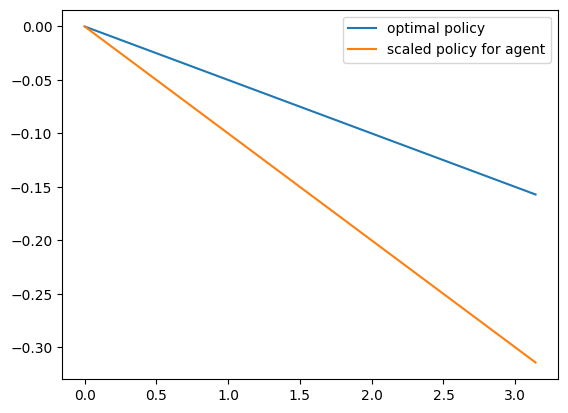

In [31]:
plt.plot(o_vals, ana_sum, label='optimal policy')
plt.plot(o_vals, ana_scaled, label='scaled policy for agent')
plt.legend()
plt.show()

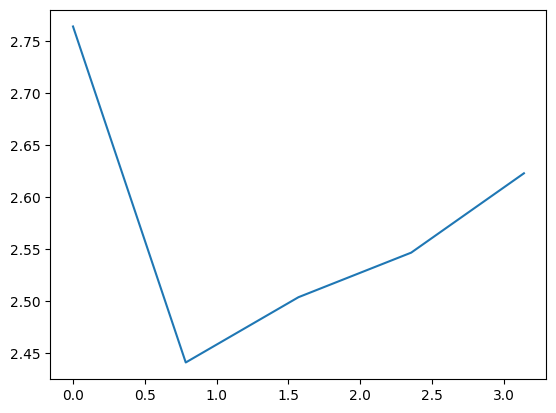

In [32]:
plt.plot(o_vals, rewards)
plt.show()

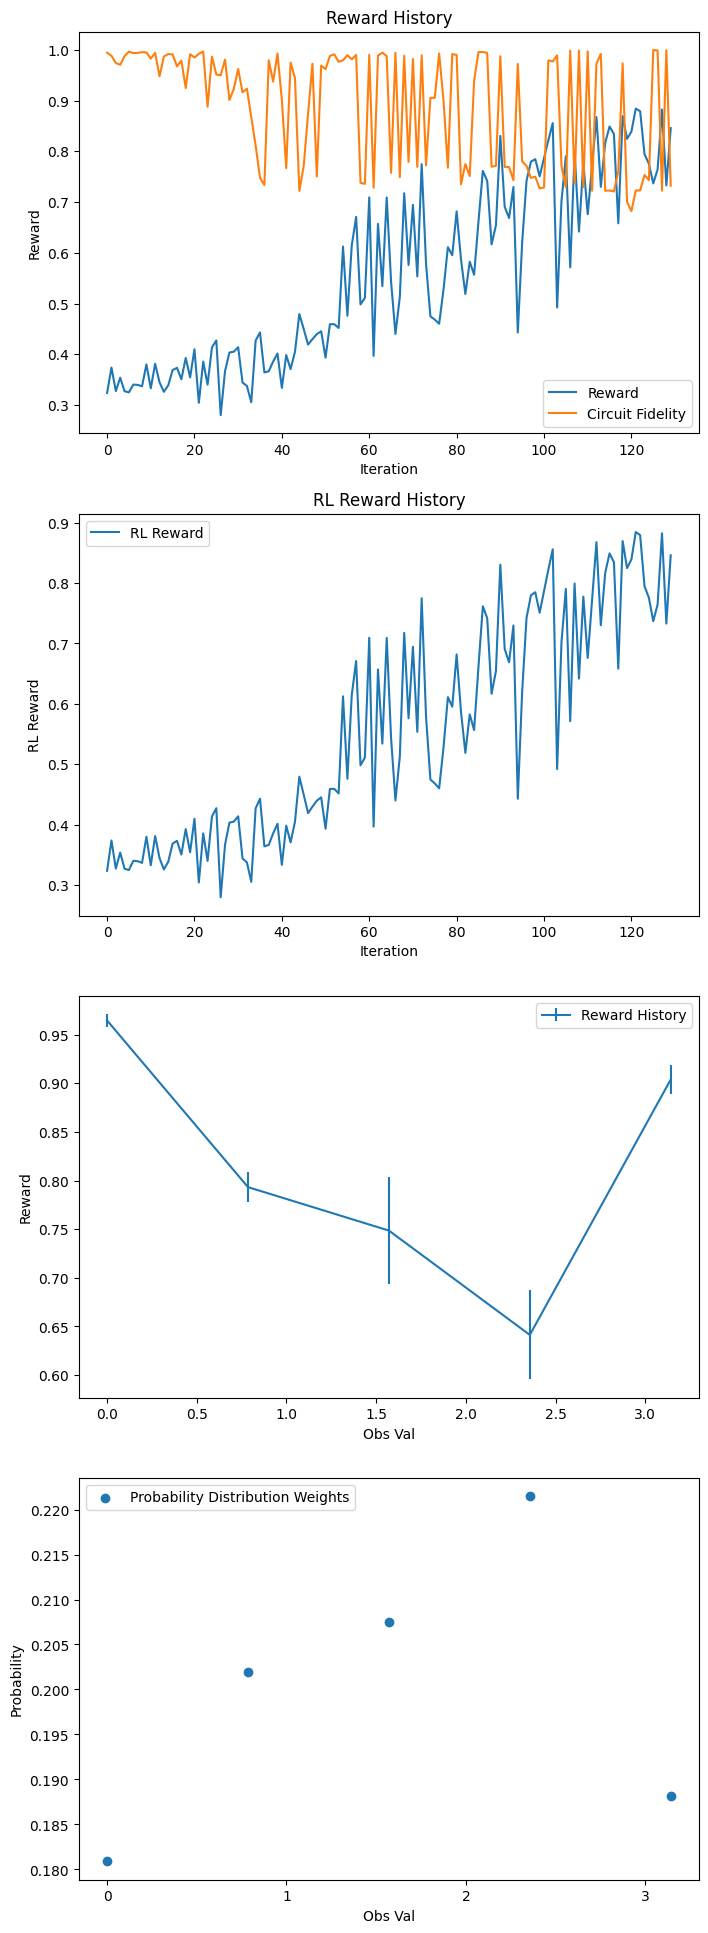

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.7637580893854358
Reward (avg): 0.8730340178554523 Std: 0.035400909092257835
obs: [-1.]
reward: [0.86506876 0.90234814 0.96128855 1.11255426 1.03519351 0.85065972
 0.70858311 1.20057448 0.8600638  0.96182346 1.0455512  0.75843547
 0.88042427 0.818469   0.89955052 0.81629176 0.87373857 1.07630544
 1.05574817 0.65966062 0.92739721 0.90229309 0.89808753 0.77898014
 0.83679576 0.93396253 1.13280011 1.03960391 0.96640061 0.84262466
 0.74221433 0.8911957 ]
Mean Action: [ 0.17195745 -0.42345962 -1.5680385   3.5247033   1.7215979   1.969118
  9.308938  ]
Sampled angles:  [0.         0.         0.         2.35619449 0.         0.        ]
Environment Observation: [0.5]
SPS: 8
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.8339338194863186


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.710225210631257 Std: 0.11310426205482207
obs: [0.5]
reward: [0.59488948 0.6089552  0.6870698  0.54080287 0.51189818 0.71746087
 0.61333764 0.66481535 0.56399201 0.52081177 0.57834614 0.65126547
 0.40352022 0.32375219 0.63088845 0.48517996 0.273082   0.69434667
 0.63487857 0.52912064 0.65411559 0.73491544 0.19796123 0.65421046
 0.52292884 0.66228178 0.71298706 0.23333113 0.68613877 0.65081257
 0.47321066 0.61635477]
Mean Action: [-0.35627714 -0.27847397 -1.8011769   2.8424082  -0.17864433 -0.0078002
 -1.9221922 ]
Sampled angles:  [0.         0.         0.         1.57079633 0.         0.        ]
Environment Observation: [0.]
SPS: 8
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.8085697410133268


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8467583490437336 Std: 0.05178133324171104
obs: [0.]
reward: [0.78931329 0.82070099 0.71696962 0.72958665 0.79507816 0.95361622
 0.73193049 0.62169342 0.86698034 0.91639403 1.03043748 0.78785038
 0.92067482 0.86464487 0.43282136 0.98333206 0.92912629 1.02097744
 0.83229595 0.93349388 0.83646096 0.91810036 0.85082223 0.74453353
 0.8658785  0.89809544 0.93695734 0.64753785 0.9250004  0.76076034
 0.84012447 0.77309127]
Mean Action: [-0.11690335 -0.30036297 -1.6423179   3.1772585   0.62659764  0.68269366
  2.5920777 ]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
SPS: 8
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.8134592589803086


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8872450872897146 Std: 0.03184520850064989
obs: [1.]
reward: [0.88428526 1.16597026 0.73418186 0.99166111 0.99858126 0.96798591
 0.79281536 1.03473757 0.80917133 1.15423354 1.01800393 0.90561536
 1.21485442 1.01220832 0.96830017 0.9764211  1.01548717 1.21782538
 0.7640299  0.85994822 1.12100827 0.84423184 0.87095282 1.15438988
 1.00321079 0.93270541 0.91808392 0.79199135 0.96823884 0.97877944
 0.87367983 0.9610559 ]
Mean Action: [-0.49149555 -0.33967242 -1.7391934   2.3945808  -0.39291072 -0.58029205
 -4.7919807 ]
Sampled angles:  [0.         0.         0.         3.14159265 0.         0.        ]
Environment Observation: [1.]
SPS: 8
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.8103609739592029


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.894533191684291 Std: 0.05410064952407031
obs: [1.]
reward: [1.18308566 1.11832271 0.92615679 1.05243474 1.1575033  1.06053481
 1.01941554 1.15221164 1.12987499 1.07842119 1.02101403 1.001329
 0.98060444 0.92469479 1.08276282 1.00245784 0.87634955 0.84163571
 0.92051592 0.95848906 1.11401625 1.21320339 1.02343786 0.97753457
 0.95653053 0.9696552  0.99706342 1.03133833 0.94768191 0.41183498
 0.99555319 1.05918469]
Mean Action: [-0.48861936 -0.27992597 -1.7858939   2.6326375  -0.41429698 -0.7815331
 -4.9297853 ]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
SPS: 8


In [36]:
ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [ ]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_angles:
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.5
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

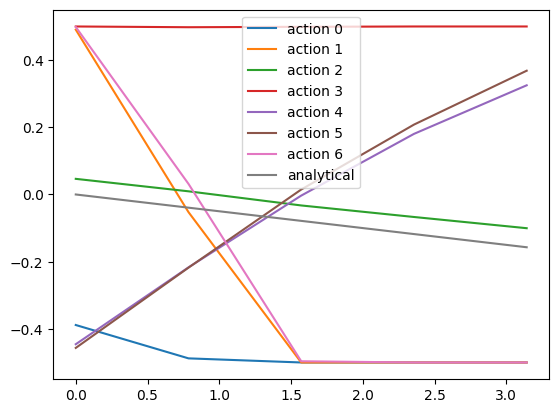

In [ ]:
actions = np.array(actions)

o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles
ana_sum = -o_vals * 0.05

for i in range(len(actions[0])):
    plt.plot(o_vals, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(o_vals, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [ ]:
# Testing fidelity of agents

import copy

rewards = []

action_test = copy.deepcopy(actions) # * 0.5

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals_angles):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = act[0] # 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = 0. # ana_sum[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    act = action_test[i]
    batch_action = np.tile(act, (one_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9701928778203686
Reward (avg): 0.9701928778203686 Std: 0.0
obs: [-1.]
reward: [3.51300791 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791
 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791
 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791
 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791
 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791 3.51300791
 3.51300791 3.51300791]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9604407290131596
Reward (avg): 0.9604407290131596 Std: 0.0
obs: [-0.5]
reward: [3.2299552 3.2299552 3.2299552 3.2299552 3.229955

In [ ]:
baseline_rewards = []

# action_test = copy.deepcopy(actions)

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals_angles):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = ana_sum[i]
    act[1] = 0.
    act[2] = 0.
    act[3] = 0.
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (one_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    baseline_rewards.append(np.mean(reward))

Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
obs: [-1.]
reward: [13.81551056 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056
 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056
 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056
 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056
 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056 13.81551056
 13.81551056 13.81551056]
Sampled angles:  [0.         0.         0.         0.78539816 0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999998 Std: 0.0
obs: [-0.5]
reward: [13.81551056 13.81551056 13.81551056 13.8155105

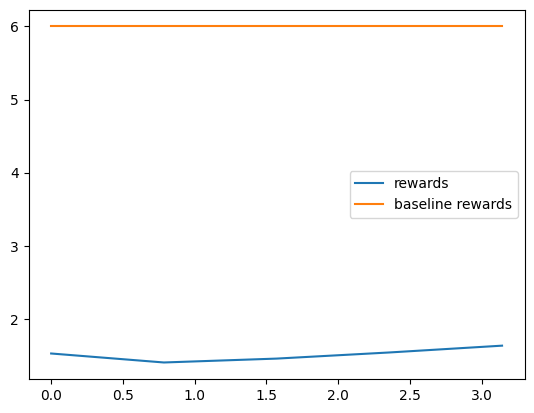

In [ ]:
plt.plot(single_n_q_env.discrete_obs_vals_angles, rewards / np.log(10), label='rewards')
plt.plot(single_n_q_env.discrete_obs_vals_angles, baseline_rewards / np.log(10), label='baseline rewards')
plt.legend()
plt.show()